# Library

In [120]:
! pip install wandb opencv-python-headless==4.1.2.30 albumentations torch-summary timm==0.5.4 einops joblib icecream  -qq -U

In [121]:
pip install matplotlib -U


In [122]:
from sklearn.metrics import f1_score
from glob import glob
import pathlib
from pathlib import Path
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pprint import pprint
import urllib.request
import csv
import numpy as np
from einops import rearrange, reduce, repeat
from torch.cuda import amp
from tqdm import tqdm
import wandb
import time
import copy
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import joblib
import gc
import os
from icecream import ic
from sklearn.model_selection import train_test_split
import gc
import cv2
import copy
import time
import random
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

import timm

import json

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


from sklearn.metrics import f1_score

In [123]:
# import wandb
# run = wandb.init(project="lg", entity="jiwon7258",
#                   job_type='EDA')

# dataset = wandb.run.use_artifact(
#     'jiwon7258/lg/csv_json:latest', type='dataset')

# # Download the artifact's contents
# dataset_dir = dataset.download()
# dataset_dir = Path(dataset_dir)


In [125]:
# dataset_dir = Path('/content/artifacts/csv_json:v1')
TRAIN_PATH = dataset_dir / 'train'
TEST_PATH = dataset_dir / 'test'

# Train Data 분석

In [126]:
train_csv = sorted(glob(str(TRAIN_PATH / '*/*.csv')))
train_json = sorted(glob(str(TRAIN_PATH / '*/*.json')))

codes = []
crops = []
diseases = []
risks = []
corp_disease_risks = []

for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        code = Path(train_json[i]).parent.stem
        sample = json.load(f)
        crop = sample['annotations']['crop']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        corp_disease_risk=f"{crop}_{disease}_{risk}"

        codes.append(code)
        crops.append(crop)
        diseases.append(disease)
        risks.append(risk)
        corp_disease_risks.append(corp_disease_risk)
        
label_unique = sorted(np.unique(corp_disease_risks))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

keyAndLabel = label_unique
labelAndKey = {value:key for key,value in zip(label_unique, range(len(label_unique)))}
train_labels = [label_unique[k] for k in corp_disease_risks] # len = train_len

In [127]:
print(f'Number Of Train Data : {len(codes)}')

Number Of Train Data : 5767


# Train_df

In [128]:
df_dict = dict(
    code = codes,
    crop = crops,
    disease = diseases,
    risk = risks,
    label = train_labels,
    crop_disease_risk = corp_disease_risks
)

In [129]:
train_df = pd.DataFrame(df_dict)
train_df.head()

,code,crop,disease,risk,label,crop_disease_risk
0,10027,3,b7,1,9,3_b7_1
1,10037,3,00,0,3,3_00_0
2,10043,3,00,0,3,3_00_0
3,10045,3,00,0,3,3_00_0
4,10063,3,00,0,3,3_00_0


# Crop 분포 살펴보기

In [130]:
crop_count = train_df['crop'].value_counts()
crop_count

3    2101
6     975
4     917
1     810
5     632
2     332
Name: crop, dtype: int64

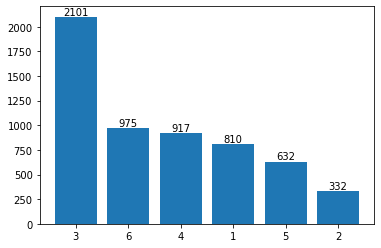

In [131]:
fig, ax = plt.subplots()
p = ax.bar(range(len(crop_count)), crop_count.values, tick_label = crop_count.index)
ax.bar_label(p, crop_count.values)
plt.show()

In [132]:
percent = crop_count.values / crop_count.sum() * 100
for idx in range(len(percent)):
  percent[idx] = format(percent[idx], '3.1f')
percent

array([36.4, 16.9, 15.9, 14. , 11. ,  5.8])

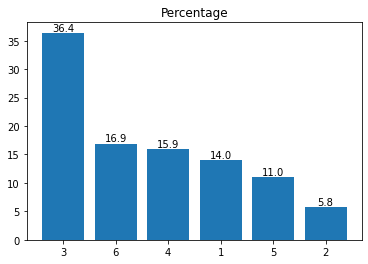

In [133]:
fig, ax = plt.subplots()
p = ax.bar(range(len(crop_count)), percent, tick_label = crop_count.index)
ax.bar_label(p, percent)
ax.set_title('Percentage')
plt.show()

In [134]:
# Disease 분포 살펴보기

# Risk 분포 살펴보기

In [135]:
risk_count = train_df['risk'].value_counts()
risk_count.head()

0    3944
1    1327
2     440
3      56
Name: risk, dtype: int64

In [136]:
percent = (risk_count.values / risk_count.sum()) * 100
for idx in range(len(percent)):
  percent[idx] = '{:.3}'.format(percent[idx])
print(percent)

[68.4   23.     7.63   0.971]


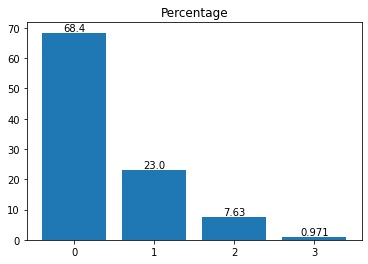

In [137]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
p = ax.bar(range(len(risk_count.index)), percent, tick_label = risk_count.index)
ax.bar_label(p, percent)
ax.set_title('Percentage')
plt.show()

- `risk == 2`, `risk == 3`인 경우에는 비율이 현저히 낮다

# 클래스(label)별 분포 살펴보기

In [138]:
label_count = train_df['label'].value_counts()
label_count.head()

3     1177
11     917
17     828
0      810
2      189
Name: label, dtype: int64

In [139]:
label_count.values

array([1177,  917,  828,  810,  189,  166,  159,  157,  156,  154,  153,
        148,  143,  142,  111,   99,   69,   42,   40,   29,   21,   18,
         14,   13,   12])

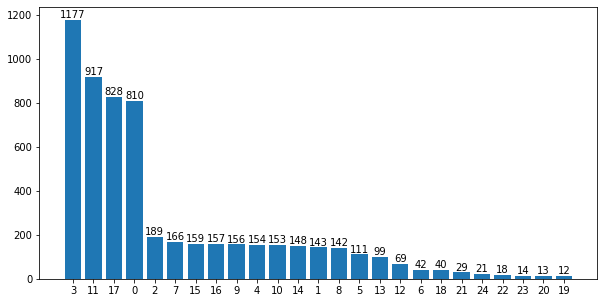

In [140]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
p = ax.bar(range(len(label_count.index)), label_count.values, tick_label = label_count.index)
ax.bar_label(p, label_count.values)
plt.show()

In [141]:
many_labels = [3,11,17]
for label in many_labels :
  print(f'{label} : {labelAndKey[label]}') 

3 : 3_00_0
11 : 4_00_0
17 : 6_00_0


- 3 : 3_00_0
- 11 : 4_00_0
- 17 : 6_00_0


이 세가지 레이블이 엄청 다수를 차지한다.
하위 8개의 레이블을 뽑아보자

In [142]:
minor_labels = label_count.index[-8:]
for label in minor_labels:
  print(f'{label} : {labelAndKey[label]}')

6 : 3_a9_3
18 : 6_a11_1
21 : 6_a12_2
24 : 6_b5_1
22 : 6_b4_1
23 : 6_b4_3
20 : 6_a12_1
19 : 6_a11_2


# 데이터 정제

- 다음 조건에 해당하는 인덱스를 모은다
  - `risk == 3`
  - `risk == 2`
  - 분포 기준, 하위 8개 레이블

In [143]:
mask = (train_df['risk'] == 3 ) | (train_df['risk'] == 2) | [ True if x in minor_labels.to_list() else False for x in train_df['label'].values ]
new = train_df.loc[mask]

## Risk 분포

In [144]:
risk_count = new['risk'].value_counts()
risk_count.head()

2    440
1     92
3     56
Name: risk, dtype: int64

In [145]:
percent = (risk_count.values / risk_count.sum()) * 100
for idx in range(len(percent)):
  percent[idx] = '{:.3}'.format(percent[idx])
print(percent)

[74.8  15.6   9.52]


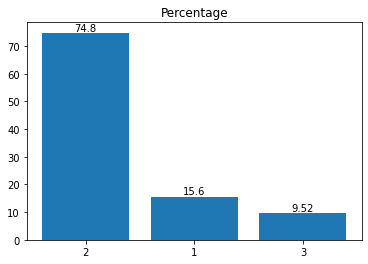

In [146]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
p = ax.bar(range(len(risk_count.index)), percent, tick_label = risk_count.index)
ax.bar_label(p, percent)
ax.set_title('Percentage')
plt.show()

## 클래스 (label) 분포 살펴보기

In [147]:
label_count = new['label'].value_counts()
label_count.head()

2     189
5     111
13     99
6      42
18     40
Name: label, dtype: int64

In [148]:
label_count.values

array([189, 111,  99,  42,  40,  29,  21,  18,  14,  13,  12])

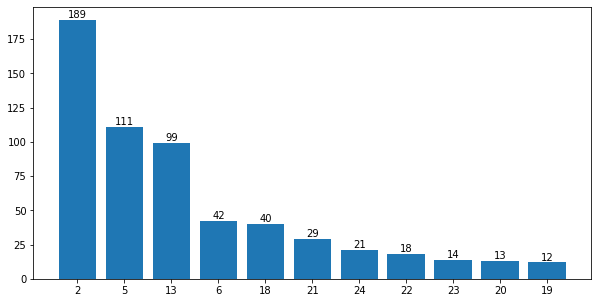

In [149]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
p = ax.bar(range(len(label_count.index)), label_count.values, tick_label = label_count.index)
ax.bar_label(p, label_count.values)
plt.show()

# 하위 8개 라벨들 분석

In [150]:
train_df.loc[train_df['risk']==3]['label'].value_counts()

6     42
23    14
Name: label, dtype: int64

## Risk 분포 

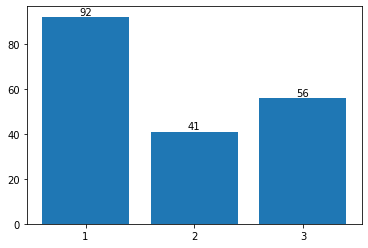

In [151]:
new2 = train_df.loc[[ True if x in minor_labels.to_list() else False for x in train_df['label'].values ]]
content = new2['risk'].value_counts()
content = content.sort_index()

fig, ax = plt.subplots()

p=ax.bar(range(len(content)), content.values, tick_label = content.index)
ax.bar_label(p, content.values)
plt.show()

In [152]:
new2.index

Int64Index([ 161,  208,  282,  290,  313,  357,  358,  435,  440,  460,
            ...
            5478, 5551, 5595, 5634, 5669, 5679, 5704, 5727, 5750, 5751],
           dtype='int64', length=189)

In [155]:
new2.index.to_list()

[161,
 208,
 282,
 290,
 313,
 357,
 358,
 435,
 440,
 460,
 476,
 498,
 555,
 566,
 581,
 618,
 667,
 685,
 741,
 773,
 800,
 820,
 838,
 925,
 941,
 971,
 973,
 992,
 1000,
 1040,
 1081,
 1108,
 1145,
 1178,
 1180,
 1227,
 1284,
 1301,
 1322,
 1341,
 1349,
 1360,
 1419,
 1503,
 1548,
 1560,
 1614,
 1616,
 1656,
 1697,
 1731,
 1734,
 1736,
 1771,
 1863,
 1877,
 1893,
 1990,
 2024,
 2072,
 2094,
 2136,
 2149,
 2151,
 2152,
 2206,
 2241,
 2291,
 2337,
 2405,
 2434,
 2447,
 2459,
 2479,
 2497,
 2503,
 2531,
 2558,
 2584,
 2659,
 2713,
 2719,
 2725,
 2757,
 2812,
 2818,
 2867,
 2886,
 2898,
 2902,
 2906,
 2981,
 3044,
 3052,
 3078,
 3155,
 3160,
 3201,
 3229,
 3246,
 3278,
 3285,
 3337,
 3347,
 3391,
 3411,
 3416,
 3426,
 3445,
 3521,
 3595,
 3597,
 3625,
 3636,
 3676,
 3713,
 3748,
 3792,
 3818,
 3825,
 3967,
 3976,
 4000,
 4024,
 4027,
 4060,
 4063,
 4105,
 4117,
 4167,
 4170,
 4197,
 4253,
 4296,
 4327,
 4331,
 4335,
 4385,
 4403,
 4404,
 4419,
 4469,
 4595,
 4598,
 4610,
 4613,
 4619,

In [154]:
mask = []

# 음
- 하위 8개 라벨 중
  - 2개 (6, 23)은 Risk 3
  - 나머지는 Risk 2